# Preparation for Colab
## Pytorch version
Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will print the CUDA version of the runtime if it has a GPU, and install PyTorch 1.7.1.

In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "11.2":
    torch_version_suffix = "+cu112"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 11.0


In [ ]:
! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1MB 1.3MB/s eta 0:04:02tcmalloc: large alloc 1147494400 bytes == 0x558b9ea66000 @  0x7f027b305615 0x558b6652b06c 0x558b6660aeba 0x558b6652de8d 0x558b6661f99d 0x558b665a1fe9 0x558b6659cb0e 0x558b6652f77a 0x558b665a1e50 0x558b6659cb0e 0x558b6652f77a 0x558b6659e86a 0x558b666207c6 0x558b6659dee2 0x558b666207c6 0x558b6659dee2 0x558b666207c6 0x558b6659dee2 0x558b666207c6 0x558b666a2431 0x558b66603049 0x558b6656dc84 0x558b6652e8e9 0x558b665a2ade 0x558b6652f69a 0x558b6659da45 0x558b6659ce0d 0x558b6652f77a 0x558b6659da45 0x558b6652f69a 0x558b6659da45
     |█████████████████████████████▏  | 1055.7MB 1.2MB/s eta 0:01:23tcmalloc: large alloc 1434370048 bytes == 0x558be30bc000 @  0x7f027b305615 0x558b6652b06c 0x558b6660aeba 0x558b6652de8d 0x558b6661f99d 0x558b665a1fe9 0x558b6659cb0e 0x558b6652f77a 0x558b665a1e50 0x558b6659cb0e 0x558b6652f77a 0x558b6659e86a 0x558b666207c6 0x558b6659dee2 0

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import math
import copy
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
print("Torch version:", torch.__version__)

Torch version: 1.7.1+cu110


# Neural Machine Translation

<sup> with inputs from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html </sup>

General Reference: https://github.com/nyu-dl/NLP_DL_Lecture_Note/blob/master/lecture_note.pdf

### Install Google Translate API for Comparision

https://github.com/ssut/py-googletrans

In [ ]:
! pip install googletrans==4.0.0-rc1

  Created wheel for googletrans: filename=googletrans-4.0.0rc1-cp37-none-any.whl size=17417 sha256=b440a9dbb29b781efb6995818edae97e568358f9f32d6934be3d4e4b75b5903c
  Stored in directory: /root/.cache/pip/wheels/09/32/56/fd8940f1b3c1d77c9f91b55597c52a4d4833b000a980bb0740
Successfully built googletrans
  Found existing installation: googletrans 3.0.0
    Can't uninstall 'googletrans'. No files were found to uninstall.


In [ ]:
from googletrans import Translator
translator = Translator()

In [ ]:
translator.translate("Bonjour, ceci est un petit test").__dict__()["text"]

'Hello, this is a small test'

In [ ]:
! wget https://nyu.box.com/shared/static/jgbcjgbhgfwmpk2y2785fzsg5vlh91iu.gz

--2021-05-02 23:35:35--  https://nyu.box.com/shared/static/jgbcjgbhgfwmpk2y2785fzsg5vlh91iu.gz
Resolving nyu.box.com (nyu.box.com)... 107.152.25.197
Connecting to nyu.box.com (nyu.box.com)|107.152.25.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/jgbcjgbhgfwmpk2y2785fzsg5vlh91iu.gz [following]
--2021-05-02 23:35:35--  https://nyu.box.com/public/static/jgbcjgbhgfwmpk2y2785fzsg5vlh91iu.gz
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/jgbcjgbhgfwmpk2y2785fzsg5vlh91iu.gz [following]
--2021-05-02 23:35:35--  https://nyu.app.box.com/public/static/jgbcjgbhgfwmpk2y2785fzsg5vlh91iu.gz
Resolving nyu.app.box.com (nyu.app.box.com)... 107.152.25.201
Connecting to nyu.app.box.com (nyu.app.box.com)|107.152.25.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b1!q4C

In [ ]:
! tar xvzf jgbcjgbhgfwmpk2y2785fzsg5vlh91iu.gz

a.seq_to_seq/
a.seq_to_seq/en2fr/
a.seq_to_seq/en2fr/lang_obj/
a.seq_to_seq/en2fr/lang_obj/en_lang_obj_min_count_1.p
a.seq_to_seq/en2fr/lang_obj/fr_lang_obj_min_count_1.p
a.seq_to_seq/en2fr/nmt_enc_bow_model_dec_rnn.pth
a.seq_to_seq/en2fr/nmt_enc_rnn_model_dec_rnn.pth
a.seq_to_seq/en2fr/nmt_enc_encoderattn_model_dec_rnn.pth
a.seq_to_seq/en2fr/.ipynb_checkpoints/
a.seq_to_seq/.ipynb_checkpoints/
a.seq_to_seq/.ipynb_checkpoints/NMT-checkpoint.ipynb
a.seq_to_seq/data/
a.seq_to_seq/data/valid.fr
a.seq_to_seq/data/valid.en
a.seq_to_seq/data/train.fr
a.seq_to_seq/data/train.en
a.seq_to_seq/pyfiles/
a.seq_to_seq/pyfiles/nnet_models_new.py
a.seq_to_seq/pyfiles/.ipynb_checkpoints/
a.seq_to_seq/pyfiles/.ipynb_checkpoints/nnet_models_new-checkpoint.py
a.seq_to_seq/pyfiles/.ipynb_checkpoints/download_reqs-checkpoint.sh
a.seq_to_seq/pyfiles/__pycache__/
a.seq_to_seq/pyfiles/__pycache__/nmt_dataset.cpython-37.pyc
a.seq_to_seq/pyfiles/__pycache__/global_variables.cpython-37.pyc
a.seq_to_seq/pyfiles/_

In [ ]:
cd a.seq_to_seq

/content/a.seq_to_seq


In [ ]:
! ls

data  en2fr  NMT.ipynb	pyfiles


In [ ]:
path_to_utils = 'pyfiles'

In [ ]:
import os
import sys
sys.path.append(path_to_utils)

In [ ]:
import global_variables
import nmt_dataset
import nnet_models_new

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from functools import partial
import time
# from tqdm import tqdm_notebook as tqdm
import tqdm

In [ ]:
base_saved_models_dir = '.'

### The Dataset

We will work with a English to French Dataset from https://www.manythings.org/anki/

In [ ]:
main_data_path = './data/'

In [ ]:
source_name = 'en'
target_name = 'fr'

path_to_train_data = {'source':main_data_path+'train.'+source_name, 
                      'target':main_data_path+'train.'+target_name}
path_to_val_data = {'source': main_data_path+'valid.'+source_name, 
                      'target':main_data_path+'valid.'+target_name}

In [ ]:
saved_models_dir = os.path.join(base_saved_models_dir, source_name+'2'+target_name)

In [ ]:
## See first 5 records
! head -5 'data/train.en'

i think we may have something that you d be interested in buying .
they got it .
i m glad to see you .
he got into his car in a hurry .
do you like mozart s music ?


In [ ]:
! head -5 'data/train.fr'

je pense que nous avons peut etre quelque chose dont vous seriez interesses de faire l acquisition .
ils l ont eue .
je suis enchante de vous rencontrer .
il monta en vitesse dans sa voiture .
aimez vous la musique de mozart ?


### Processing and making PyTorch Dataset

We have to make it a pair - (source, target) sentence pair. For this, we have to read the file and parse it accordingly. We might have to take care of some details there, like making sure that we strip off any non-required special characters or extra space. All those boring details aside (which you can see in dataset_helper.py) what are the other things we have to do?

We have to make a vocabulary and tokenize like we have been doing. Here, we are writing a Language Class, to take care of this for you. Once we have done all this and tokenized, we write a pytorch dataset object to help as handle this efficiently during training

In [ ]:
saved_language_model_dir = os.path.join(saved_models_dir, 'lang_obj')

In [ ]:
dataset_dict = {'train': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_train_data, 
                    lang_obj_path = saved_language_model_dir,
                     minimum_count = 1), 

                'val': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_val_data, 
                    lang_obj_path = saved_language_model_dir,
                    minimum_count = 1)}

The LanguagePair object we built has a DataFrame underneath. We see the first 5 rows of the dataframe below:

In [ ]:
dataset_dict['train'].main_df.iloc[:5]

,source_data,target_data,source_tokenized,source_len,target_tokenized,target_len,source_indized,target_indized
0,i think we may have something that you d be in...,je pense que nous avons peut etre quelque chos...,"[i, think, we, may, have, something, that, you...",15,"[je, pense, que, nous, avons, peut, etre, quel...",19,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
1,they got it .,ils l ont eue .,"[they, got, it, .]",5,"[ils, l, ont, eue, .]",6,"[18, 19, 20, 17, 3]","[22, 19, 23, 24, 21, 3]"
2,i m glad to see you .,je suis enchante de vous rencontrer .,"[i, m, glad, to, see, you, .]",8,"[je, suis, enchante, de, vous, rencontrer, .]",8,"[4, 21, 22, 23, 24, 11, 17, 3]","[4, 25, 26, 17, 14, 27, 21, 3]"
3,he got into his car in a hurry .,il monta en vitesse dans sa voiture .,"[he, got, into, his, car, in, a, hurry, .]",10,"[il, monta, en, vitesse, dans, sa, voiture, .]",9,"[25, 19, 26, 27, 28, 15, 29, 30, 17, 3]","[28, 29, 30, 31, 32, 33, 34, 21, 3]"
4,do you like mozart s music ?,aimez vous la musique de mozart ?,"[do, you, like, mozart, s, music, ?]",8,"[aimez, vous, la, musique, de, mozart, ?]",8,"[31, 11, 32, 33, 34, 35, 36, 3]","[35, 14, 36, 37, 17, 38, 39, 3]"


### vocabulary sizes and sentence lengths

In [ ]:
### vocabulary sizes
print('source vocab: ', dataset_dict['train'].source_lang_obj.n_words , 
      'target vocab: ', dataset_dict['train'].target_lang_obj.n_words)

source vocab:  12392 target vocab:  20111


In [ ]:
### sentence lengths
print('max len: ', dataset_dict['train'].main_df['source_len'].max(), 
      'min len: ', dataset_dict['train'].main_df['source_len'].min() )

max len:  51 min len:  3


In [ ]:
dataset_dict['train'].main_df['source_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     8.0
0.7500    10.0
0.9000    12.0
0.9500    13.0
0.9900    17.0
0.9990    22.0
0.9999    32.0
Name: source_len, dtype: float64

51 looks like a very long sentence and at the $99.99$th percentile is 32. We probably don't want that much. How do we get rid of rest of the words or clip sentence at some MAX LEN? We can use the collate function of pytorch that we had seen earlier to do this. 

In [ ]:
MAX_LEN = int(dataset_dict['train'].main_df['source_len'].quantile(0.9999))
batchSize = 64

In [ ]:
dataloader_dict = {'train': DataLoader(dataset_dict['train'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0), 
                    'val': DataLoader(dataset_dict['val'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0) }

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of usually of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence. Essentially, all we need is some mechanism to read the source sentence and create an encoding and some mechanism to read the encoding and decode it to the target language. 

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "I am not the
black cat" → "Je ne suis pas le chat noir". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




### Concepts:
1. NMT as a conditional language modelling
2. Encoder
3. Decoding during evaluation - step by step (see code)
4. Teaching Forcing (see code) and train step
5. How do we evaluate the quality of translation?

The Encoder
-----------

The encoder is anything which takes in a sentence and gives us a representation for the sentence. 

Usually, the encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

However, we will first start with a BoW encoder and then move on to RNN based encoders

In [ ]:
### configuration
source_lang_obj = dataset_dict['train'].source_lang_obj
target_lang_obj = dataset_dict['train'].target_lang_obj

source_vocab = dataset_dict['train'].source_lang_obj.n_words;
target_vocab = dataset_dict['train'].target_lang_obj.n_words;
hidden_size = 512
rnn_layers = 1
lr = 0.25;
longest_label = 32;
gradient_clip = 0.3;
use_cuda = True

num_epochs = 10

### BagOfWords Encoder

In [ ]:
encoder_bow = nnet_models_new.BagOfWords(input_size = source_vocab,
                                    hidden_size = hidden_size, 
                                    nlayers=4, 
                                    reduce = "sum")

In [ ]:
print(encoder_bow)

BagOfWords(
  (embedding): Embedding(12392, 512, padding_idx=0)
  (layers): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=512, out_features=512, bias=True)
  )
)


The Decoder
--------------------


The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

Decoder w/o Attention
------------------------
In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder's last hidden state).

In [ ]:
decoder_bow = nnet_models_new.DecoderRNN(target_vocab, hidden_size, rnn_layers)

In [ ]:
print(decoder_bow)

DecoderRNN(
  (embedding): Embedding(20111, 512)
  (gru): GRU(512, 512, batch_first=True)
  (out): Linear(in_features=512, out_features=20111, bias=True)
  (softmax): LogSoftmax(dim=2)
)


In [ ]:
nmt_bow = nnet_models_new.seq2seq(encoder_bow, decoder_bow,
                              lr = 1e-2, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = 4,
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

### Training Loop

In [ ]:
def get_full_filepath(path, enc_type):
    filename = 'nmt_enc_'+enc_type+'_dec_rnn.pth'
    return os.path.join(path, filename)

In [ ]:
def save_models(nmt_model, path, enc_type):
    if not os.path.exists(path):
            os.makedirs(path)
    filename = 'nmt_enc_'+enc_type+'_dec_rnn.pth'
    torch.save(nmt_model, os.path.join(path, filename))
   

In [ ]:
def train_model(dataloader, nmt, num_epochs=50, val_every=1, saved_model_path = '.', enc_type ='rnn'):

    best_bleu = -1;
    for epoch in range(num_epochs):

        start = time.time()
        running_loss = 0

        print('Epoch: [{}/{}]'.format(epoch, num_epochs));
        
        for i, data in tqdm.tqdm_notebook(enumerate(dataloader['train']), total=len(dataloader['train'])):  
            _, curr_loss = nmt.train_step(data);
            running_loss += curr_loss

        epoch_loss = running_loss / len(dataloader['train']) 
        
        print("epoch {} loss = {}, time = {}".format(epoch, epoch_loss,
                                                        time.time() - start))
        sys.stdout.flush()
   
        if epoch%val_every == 0:
            val_bleu_score = nmt.get_bleu_score(dataloader['val']);
            print('validation bleu: ', val_bleu_score)
            sys.stdout.flush()
            
            nmt.scheduler_step(val_bleu_score);
            
            if val_bleu_score > best_bleu:
                best_bleu = val_bleu_score
                save_models(nmt, saved_model_path, enc_type);

        print('='*50)

    print("Training completed. Best BLEU is {}".format(best_bleu))

    

### Training Bow Encoder GRU Decoder Model

In [ ]:
train_again = False
modelname = 'bow_model'
device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu');
if os.path.exists(get_full_filepath(saved_models_dir, modelname)) and (not train_again):
    nmt_bow = torch.load(get_full_filepath(saved_models_dir, modelname))
else:
    train_model(dataloader_dict, nmt_bow, 
                          num_epochs = num_epochs, 
                          saved_model_path = saved_models_dir, 
                          enc_type = 'bow_test')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or s

### Check Performance

In [ ]:
nmt_bow = nmt_bow.to(device)

In [ ]:
print(nmt_bow.get_bleu_score(dataloader_dict['val']))

21.839684366840807


## Interacting with the system

In [ ]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import copy
%matplotlib inline


def get_binned_bl_score(nmt_model, val_dataset):
    
    len_threshold = np.arange(0, 31, 5)
    bin_bl_score = np.zeros(len(len_threshold));
    
    for i in tqdm.tqdm_notebook( range(1, len(len_threshold)), total = len(len_threshold)-1):
        min_len = len_threshold[i-1]
        max_len = len_threshold[i]
        
        temp_dataset = copy.deepcopy(val_dataset);
        temp_dataset.main_df = temp_dataset.main_df[(temp_dataset.main_df['source_len'] > min_len) & (temp_dataset.main_df['source_len'] <= max_len)];
        temp_loader = DataLoader(temp_dataset, batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=100),
                            shuffle = True, num_workers=0)
        
        bin_bl_score[i] = nmt_model.get_bleu_score(temp_loader);
        
    
    len_threshold = len_threshold[1:]
    bin_bl_score = bin_bl_score[1:]
    
    plt.plot(len_threshold, bin_bl_score, 'x-')
    plt.ylim(0, np.max(bin_bl_score)+1)
    plt.xlabel('len')
    plt.ylabel('bl score')
    
    return len_threshold, bin_bl_score
    
        
        
    
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone', aspect='auto')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       [global_variables.EOS_TOKEN], rotation=90)
    ax.set_yticklabels([''] + output_words.split(' ')+
                       [global_variables.EOS_TOKEN]);

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def get_encoded_batch(sentence, lang_obj, use_cuda):
    """ accepts only bsz = 1.
        input: one sentence as a string
        output: named tuple with vector and length"""
    
    sentence = sentence + ' ' + global_variables.EOS_TOKEN;
    tensor = source_lang_obj.txt2vec(sentence).unsqueeze(0)
    
    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu');
    
    named_returntuple = namedtuple('namedtuple', ['text_vecs', 'text_lens', 'label_vecs', 'label_lens', 'use_packed'])
    return_tuple = named_returntuple( tensor.to(device), 
                                     torch.from_numpy(np.array([tensor.shape[-1]])).to(device),
                                     None,
                                     None,
                                     False );

    return return_tuple

def get_translation(nmt_model, sentence, lang_obj, use_cuda):
    print('souce: ', sentence)
    batch = get_encoded_batch(sentence, lang_obj, use_cuda);
    
    prediction, attn_scores_list = nmt_model.eval_step(batch, return_attn = True);
    prediction = prediction[0];
    print('prediction: ', prediction)
    print('Google Translate on sentence (src->tgt): ', translator.translate(sentence, 
                                                     src = source_name,
                                                     dest = target_name).text)
    print('Google Translate on prediction (tgt->src): ', translator.translate(prediction, 
                                                     src = target_name,
                                                     dest = source_name).text)

    if attn_scores_list[0] is not None:
        if attn_scores_list[0][0] is not None:
            attn_matrix = [x[0].data.cpu().numpy() for x in attn_scores_list];
            attn_matrix = np.stack(attn_matrix)[:,:, 0]
            showAttention(sentence, prediction, attn_matrix)

In [ ]:
get_translation(nmt_bow, 'how are you ?', source_lang_obj, use_cuda)

souce:  how are you ?
prediction:  comment etes vous ?
GT on sentence (src->tgt):  Comment allez-vous ?
GT on prediction (tgt->src):  How are you ?


In [ ]:
get_translation(nmt_bow, 'are hello ? how you', source_lang_obj, use_cuda)

souce:  are hello ? how you
prediction:  comment etes vous en train de faire ?
GT on sentence (src->tgt):  sont bonjour?comment vous
GT on prediction (tgt->src):  How are you doing?


## RNN Encoder

In [ ]:
encoder_rnn = nnet_models_new.EncoderRNN(source_vocab, hidden_size, rnn_layers)

In [ ]:
print(encoder_rnn)

EncoderRNN(
  (embedding): Embedding(12392, 512, padding_idx=0)
  (gru): GRU(512, 512, batch_first=True)
)


In [ ]:
decoder_rnn = nnet_models_new.DecoderRNN(target_vocab, hidden_size, rnn_layers)

In [ ]:
print(decoder_rnn)

DecoderRNN(
  (embedding): Embedding(20111, 512)
  (gru): GRU(512, 512, batch_first=True)
  (out): Linear(in_features=512, out_features=20111, bias=True)
  (softmax): LogSoftmax(dim=2)
)


In [ ]:
nmt_rnn = nnet_models_new.seq2seq(encoder_rnn, decoder_rnn,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

In [ ]:
train_again = False
modelname = 'rnn_model'
if os.path.exists(get_full_filepath(saved_models_dir, modelname)) and (not train_again):
    nmt_rnn = torch.load(get_full_filepath(saved_models_dir, modelname)).to(device)
else:
    train_model(dataloader_dict, nmt_rnn, 
                      num_epochs = num_epochs, 
                      saved_model_path = saved_models_dir, 
                      enc_type = 'rnn_test')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.GRU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.

### Check Performance

In [ ]:
print(nmt_rnn.get_bleu_score(dataloader_dict['val']))

26.298743054003605


### Interacting with system

In [ ]:
get_translation(nmt_rnn, 'how are you ?', source_lang_obj, use_cuda)

souce:  how are you ?
prediction:  comment etes vous vous en train de vous etre ?
GT on sentence (src->tgt):  Comment allez-vous ?
GT on prediction (tgt->src):  How are you doing to you?


In [ ]:
get_translation(nmt_rnn, 'are hello ? how you', source_lang_obj, use_cuda)

souce:  are hello ? how you
prediction:  comment as tu fait ?
GT on sentence (src->tgt):  sont bonjour?comment vous
GT on prediction (tgt->src):  How did you do ?


In [ ]:
get_translation(nmt_rnn, 'i know that the last thing you want to do is help me .', source_lang_obj, use_cuda)

souce:  i know that the last thing you want to do is help me .
prediction:  je sais que vous veuillez faire est ce que la derniere chose que moi .
GT on sentence (src->tgt):  Je sais que la dernière chose que vous voulez faire est d'aider moi.
GT on prediction (tgt->src):  I know you can do is what the last thing as me.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


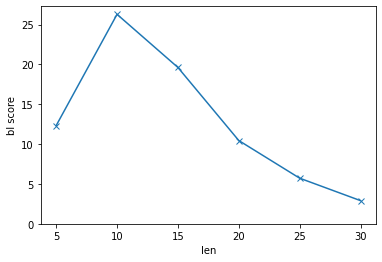

In [ ]:
rnn_len_threshold, rnn_bin_bl = get_binned_bl_score(nmt_rnn, dataset_dict['val'])

We work with a small training data and hence you see this drop in BLEU score for sentences of shorter length. We don't have enough data points with small sentence length

## RNN Encoder + Source Side Attention

### Concepts:
1. Context Vector which gives additional information from source side for decoding the next token. 
2. Fit context vector into decoding framework: <br>
    a) Initiaze with 0 <br>
    b) input to RNN is the concatenation of the input token and context vector <br>
    c) output token decoded from context vector calculated from the hidden of previous timestep; i.e, context vector for the next timestep is used for decoding the current output
3. Calculating the context vector. Explain attention module: <br>
    a) hidden transformed to encoder hidden dimension using linear layer. This is your query vector. <br> 
    b) Value and Key vectors are the encoder outputs. <br>
    c) Dot product. Raw Score. Softmax. Linear Combination. <br>
    d) contactenated the linear combination vector with the input hidden from decoder. Pass it through a linear layer to project it back to decoder hidden dimension followed by a `tanh`.  

    
    

![SegmentLocal](attention.gif "segment")

In [ ]:
encoder_attention = True
self_attention = False

In [ ]:
encoder_encoderattn = nnet_models_new.EncoderRNN(source_vocab, hidden_size, 1)

In [ ]:
decoder_encoderattn = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
                                 hidden_size=hidden_size, 
                                 encoder_attention = encoder_attention,
                                 self_attention = self_attention)

In [ ]:
nmt_encoderattn = nnet_models_new.seq2seq(encoder_encoderattn, decoder_encoderattn,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

In [ ]:
train_again = False
modelname = 'encoderattn_model'
if os.path.exists(get_full_filepath(saved_models_dir, modelname)) and (not train_again):
    nmt_encoderattn = torch.load(get_full_filepath(saved_models_dir, modelname))
else:
    train_model(dataloader_dict, nmt_encoderattn, 
                      num_epochs = num_epochs, 
                      saved_model_path = saved_models_dir, 
                      enc_type = 'encoderattn_test')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.GRU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.GRUCell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Mo

### Check Performance

In [ ]:
print(nmt_encoderattn.get_bleu_score(dataloader_dict['val']))

38.72150872314742


### BLEU vs Sentence Length

/misc/vlgscratch4/BowmanGroup/pmh330/virtual_envs/venv_metaqa/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


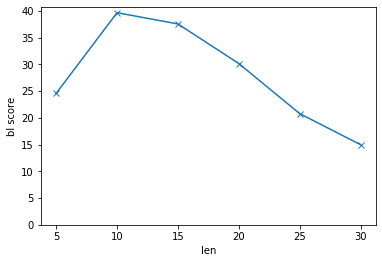

In [ ]:
attn_len_threshold, attn_bin_bl = get_binned_bl_score(nmt_encoderattn, dataset_dict['val'])

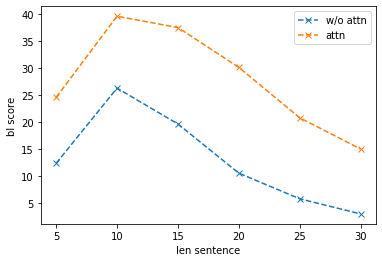

In [ ]:
plt.plot(rnn_len_threshold, rnn_bin_bl, '--x', label = 'w/o attn')
plt.plot(attn_len_threshold, attn_bin_bl, '--x', label = 'attn')
plt.xlabel('len sentence')
plt.ylabel('bl score')
plt.legend()

### Interacting with system

souce:  how are you ?
prediction:  comment allez vous ?
GT on sentence (src->tgt):  Comment allez-vous ?
GT on prediction (tgt->src):  how are you ?


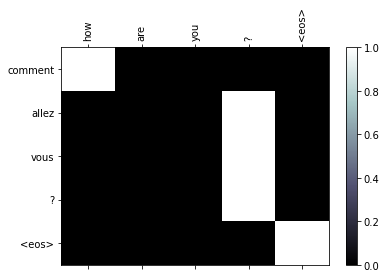

In [ ]:
get_translation(nmt_encoderattn, 'how are you ?', source_lang_obj, use_cuda)

souce:  she knows better than to argue with him .
prediction:  elle sait mieux que de ne pas le disputer avec lui .
GT on sentence (src->tgt):  Elle sait mieux que de discuter avec lui.
GT on prediction (tgt->src):  She knows better than not competing with him.


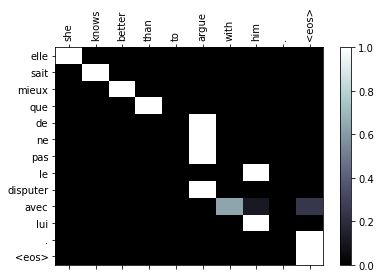

In [ ]:
get_translation(nmt_encoderattn, 'she knows better than to argue with him .', source_lang_obj, use_cuda)

souce:  she s five years younger than me .
prediction:  elle a cinq ans de moins que moi .
GT on sentence (src->tgt):  Elle a cinq ans plus jeune que moi.
GT on prediction (tgt->src):  She is five years old less than me.


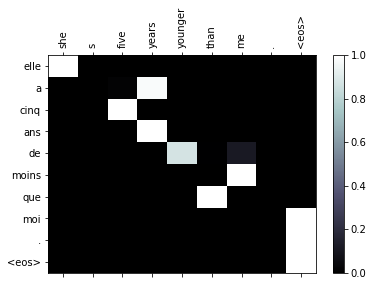

In [ ]:
get_translation(nmt_encoderattn, 'she s five years younger than me .', source_lang_obj, use_cuda)

souce:  i know that the last thing you want to do is help me .
prediction:  je sais que la derniere chose que tu veuilles faire est de m aider .
GT on sentence (src->tgt):  Je sais que la dernière chose que vous voulez faire est d'aider moi.
GT on prediction (tgt->src):  I know the last thing you want to do is help me.


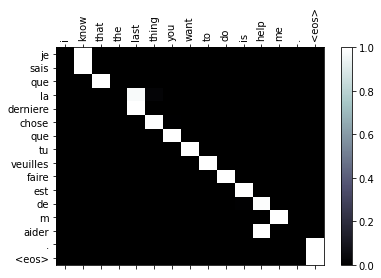

In [ ]:
get_translation(nmt_encoderattn, 'i know that the last thing you want to do is help me .', source_lang_obj, use_cuda)